In [171]:
!pip install nmrglue
!pip install peakutils
!pip install scikit-ued
from sys import path_hooks
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd
from peakutils import baseline
import os
import skued

In [170]:
class SpectraSequence:
    def __init__(self, file_path, sequence, order, apply_mask=True):
        self.file_path = file_path
        self.df = pd.read_csv(os.path.join(self.file_path, 'dict.csv'))
        self.sequence = list(sequence)
        self.data = []
        self.dic = []
        self.peak_width = []
        self.center = []
        self.region = []
        self.at = []
        self.phases = []
        self.spectras = []
        self.freqs = []
        self.id = {'noize_idx': [], 'im_idx': [], 're_idx': []}
        self.areas = []
        self.read_files()
        self.size = [len(self.sequence), len(self.data[0]), [len(self.data[i][0]) for i in range(len(self.data))]]
        self.proper_phases()
        self.perform_fourier()
        self.spectras, self.freqs = self.apply_mask(apply_mask)
        self.noize_spectra_idx()
        self.identify()

    def read_files(self):
        for i in range(len(self.sequence)):
            tmp = os.path.join(self.file_path, self.sequence[i])
            d, da = ng.varian.read(tmp)
            self.data.append(da)
            self.dic.append(d)
            self.at.append(float(self.dic[i]['procpar']['at']['values'][0]))
            filtered_df = self.df[self.df['nucleus'] == self.sequence[i]]
            if len(filtered_df) == 0:
                raise TypeError("Проверьте файл dict.csv на корректность данных, либо корректность последовательности")
            self.peak_width.append(filtered_df['peak_width'].values[0])
            self.center.append(filtered_df['center'].values[0])
            self.region.append(filtered_df['borders'].values[0])

    def proper_phases(self):
        for i in range(self.size[0]):
            spectrum_unpr = np.fft.fft(self.data[i][0])
            spectrum, phase = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
            self.phases.append(phase)

    def noize_spectra_idx(self):
        if len(self.size) == 0:
            raise ValueError('Сначала выполните фурье .perform_fourier()')
        tmp = []
        for i in range(self.size[0]):
            max_vals = []
            for k in range(self.size[1]):
                spectrum = self.spectras[i][k]
                maxima = max(np.real(spectrum))
                max_vals.append(maxima)
            threshold = np.mean(max_vals) / 2
            indices = [i for i, value in enumerate(max_vals) if value < threshold]
            tmp.append(indices)
            if len(tmp[i]) != 9:
                raise ValueError('Убедитесь, что спектр ' + self.sequence[i] + ' достаточно четкий, либо подберите treshhold внутри метода')
        return tmp

    def identify(self):
        if len(self.size) == 0:
            raise ValueError('Сначала выполните фурье .perform_fourier()')
        tmp = self.noize_spectra_idx()
        for i in range(self.size[0]):
            n_i = tmp[i]
            i_i = []
            r_i = []
            for j in range(self.size[1]-1):
                spec = self.spectras[i][j+1]
                spec_re = ((np.real(spec) / max(abs(np.real(spec))))*3)
                spec_im = ((np.imag(spec) / max(abs(np.imag(spec))))*3)
                if j+1 not in n_i and np.std(spec_re) > np.std(spec_im):
                    i_i.append(j+1)
                elif j+1 not in n_i and np.std(spec_re) < np.std(spec_im):
                    r_i.append(j+1)
            self.id['noize_idx'].append(n_i)
            self.id['im_idx'].append(i_i)
            self.id['re_idx'].append(r_i)


    def perform_fourier(self, apply_mask = True):
        if len(self.phases) == 0:
            raise ValueError('Перед выполнением фурье выполните коррекцию фазы (метод proper_phases())')
        for i in range(self.size[0]):
            freq = np.fft.fftfreq(len(self.data[i][0]), self.at[i] / len(self.data[i][0]))
            self.freqs.append(freq)
            spec_set = []
            for j in range(self.size[1]):
                spectrum = np.fft.fft(self.data[i][j]) * np.exp(1j * 2 * np.pi / 360 * (self.phases[i][0]))
                spec_set.append(spectrum)
            self.spectras.append(spec_set)


    def prepare_spectras(self, k):
        p_s = []
        for i in range(self.size[0]):
            t = []
            for j in range(self.size[1]):
                if j in self.id['im_idx'][i]:
                    corr = (-np.imag(self.spectras[i][j]) / max(-np.imag(self.spectras[i][j])) * k)**5
                    t.append(corr / max(corr))
                elif j in self.id['re_idx'][i]:
                    corr = (np.real(self.spectras[i][j]) / max(np.real(self.spectras[i][j])) * k)**5
                    t.append(corr/max(corr))
                else:
                    t.append(self.spectras[i][j] / max(self.spectras[i][j]))
            p_s.append(t)
        return p_s

    def locate_peaks(self, k):
        p_s = self.prepare_spectras(k)
        peaks = []
        for i in range(self.size[0]):
            peaks_set = []
            for j in range(self.size[1]):
                peaks_subset = []
                if j not in self.id['noize_idx'][i] and j != 0:
                    loc_peaks = ng.analysis.peakpick.pick(p_s[i][j], 0.05, -0.2)
                    for k in range(len(loc_peaks)):
                        peaks_subset.append(int(loc_peaks[k][0]))
                else: peaks_subset.append(None)
                peaks_set.append(peaks_subset)
            peaks.append(peaks_set)
        return(peaks)


    def correct_baselines(self, iter):
        for i in range(self.size[0]):
            for j in self.id['re_idx'][i]:
                bl = skued.baseline_dwt(self.spectras[i][j], iter)
                self.spectras[i][j] -= bl


    def apply_mask(self, apply_mask):
        spectras = []
        frequencies = []
        for i in range(self.size[0]):
            freq = self.freqs[i]
            if apply_mask:
                mask = (freq >= self.center[i] - self.region[i]) & (freq <= self.center[i] + self.region[i])
                frequencies.append(freq[mask])
                spec_set = []
                for j in range(self.size[1]):
                    spectrum = self.spectras[i][j]
                    spec_set.append(spectrum[mask])
                spectras.append(spec_set)
            else:
                frequencies.append(freq)
                spec_set = []
                for j in range(self.size[1]):
                    spectrum = self.spectras[i][j]
                    spec_set.append(spectrum)
                spectras.append(spec_set)
        return spectras, frequencies

    def calculate_areas(self, peaks):
        for i in range(self.size[0]):
            areas = []
            dnu = self.freqs[i][1] - self.freqs[i][0]
            for j in range(self.size[1]):
                areas_ss = 0
                for k in range(len(peaks[i][j])):
                  if peaks[i][j][k] != None:
                    left = peaks[i][j][k] - int(self.peak_width[i] / dnu)
                    right = peaks[i][j][k] + int(self.peak_width[i] / dnu)
                    area = np.trapz(np.real(self.spectras[i][j][left:right]), self.freqs[i][left:right])
                    areas_ss += area
                    print(left,right)
                areas.append(areas_ss)
            self.areas.append(areas)
        return self.areas

    def plot(self):


In [169]:
order = [
    "11x", "11y", "1xx", "1xy", "1yx", "1yy", "x1x", "x1y", "xxx", "xxy",
    "xyx", "xyy", "y1x", "y1y", "yxx", "yxy", "yyx", "yyy", "111", "1x1",
    "1y1", "x11", "xx1", "xy1", "y11", "yx1", "yy1"
]
iter = 1
ss = SpectraSequence(r'test', 'HCN', order, apply_mask=True);
ss.correct_baselines(iter)
peaks = ss.locate_peaks(k=3)
print(ss.calculate_areas(peaks))
for i in range(ss.size[0]):
  print(len(ss.id['im_idx'][i]), len(ss.id['re_idx'][i]), len(ss.id['noize_idx'][i]))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 7195.347037
         Iterations: 114
         Function evaluations: 220
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
14.999296
15.000504000049999
15.000504000049999
15.000504000049999
15.000504000049999
15.000504000049999
15.0005040

/usr/local/lib/python3.10/dist-packages/skued/baseline/algorithms.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.asarray(array, dtype=float)


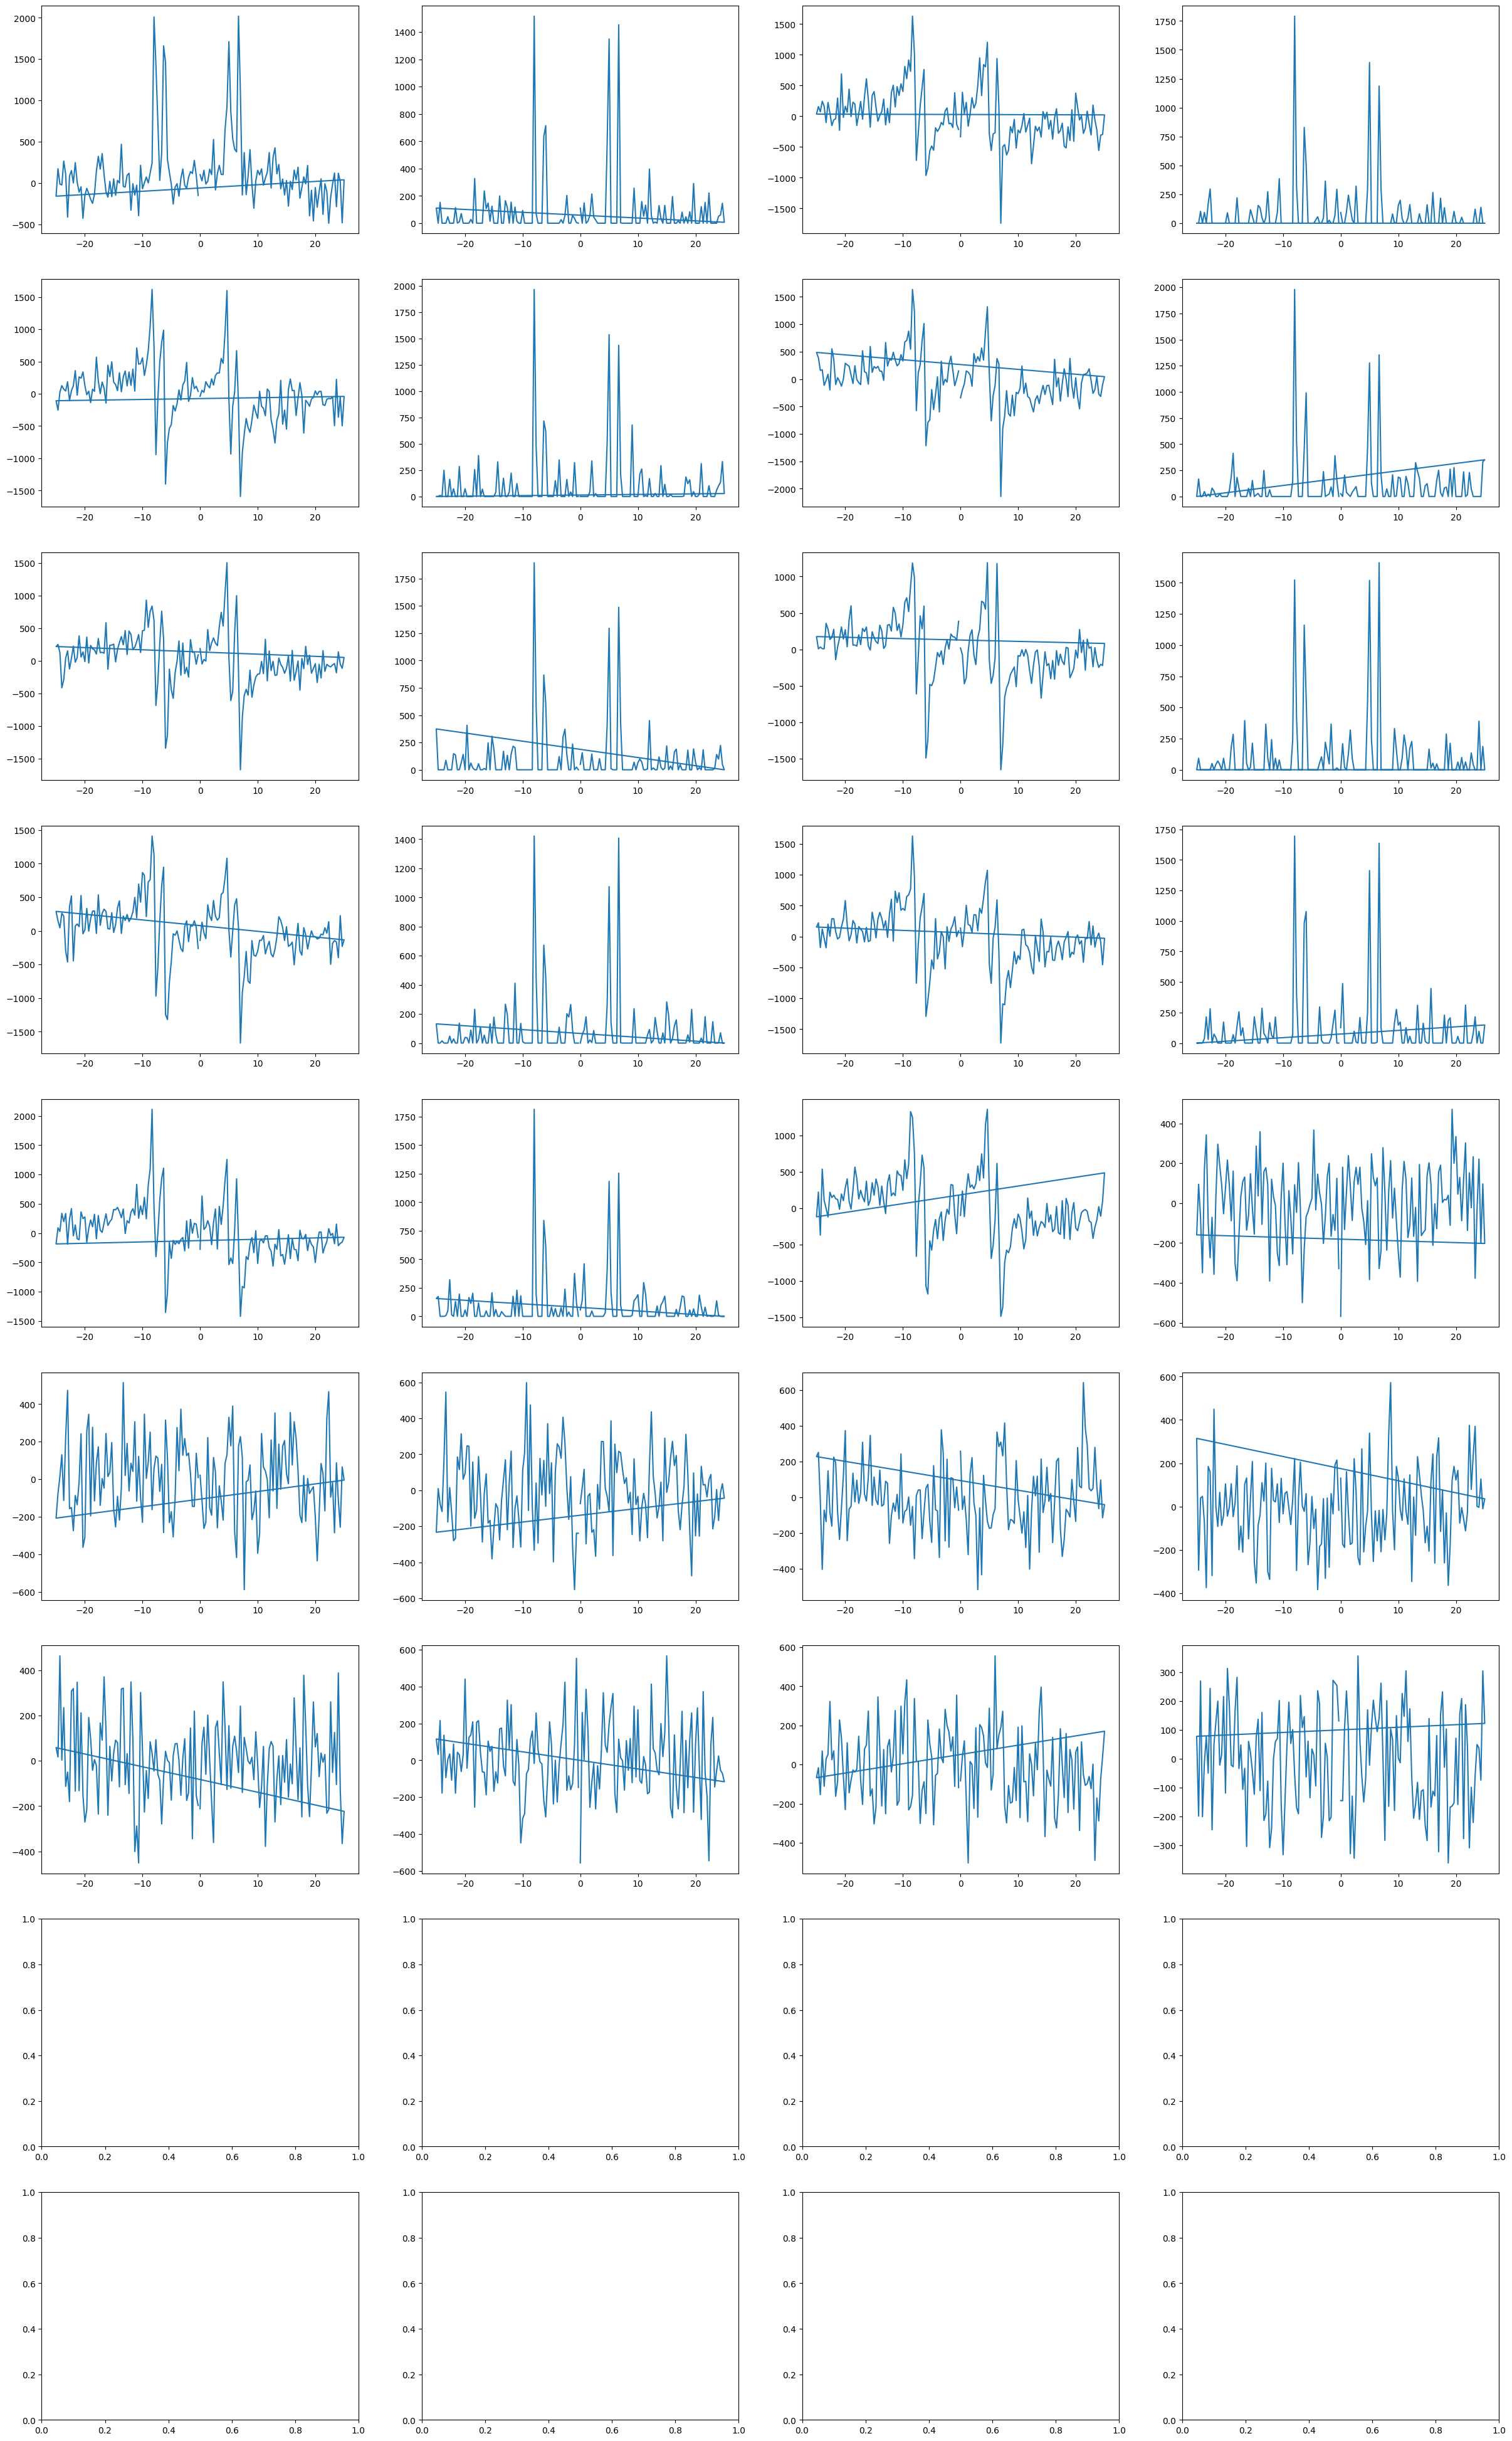

In [103]:
fig, axs = plt.subplots(9, 4, figsize=(30, 50))
axs = axs.flatten()
for idx in range(ss.size[1]):
    axs[idx].plot(ss.freqs[2], np.real(ss.spectras[2][idx]))
plt.show()

In [118]:
type(None)

NoneType

In [ ]:
from scipy import signal

def proper_phases(data, window):
    spectrum_unpr = np.fft.fft(window * data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def noize_spectra_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices



tn = 'C' # Название исследуемого ядра

dic, data = ng.varian.read(r'test//C')
df = pd.read_csv('test//dict.csv')
filtered_df = df[df['nucleus'] == 'C']
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

window = 1
phases = proper_phases(data, window)
id_idx = noize_spectra_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 4, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(window * (data[idx]))[mask]
        ph_corrected_spectrum = np.real(spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0])))
        normalized_spectrum = ph_corrected_spectrum / max(ph_corrected_spectrum)
        bl = baseline(ph_corrected_spectrum, 3)
        corrected_spectrum = ph_corrected_spectrum - bl
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)
        iter = 1
        area_indices = []
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            # area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])
            # integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)

for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        # axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        # axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

NameError: name 'ng' is not defined

NameError: name 'proper_phases' is not defined